In [1]:
import time
import requests
import pandas as pd
from datetime import datetime, date, time as dt_time, timedelta
from zoneinfo import ZoneInfo
from IPython.display import clear_output
import requests
import pandas_ta as ta
from rdp import rdp
import talib
import numpy as np
import pandas_ta as ta
from scipy.stats import zscore
from scipy.signal import savgol_filter
from datetime import datetime, date, time as dt_time, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# 


# ── CONFIG ─────────────────────────────────────────────────────────────────
API_KEY = "vBRy5un9PuHfxFj1IrHpfg8a2RS57jE9"

# https://github.com/polygon-io/client-python/blob/master/examples/websocket/stocks-ws.py

In [2]:
def fetch_polygon_data(ticker: str, api_key: str,
                              start_date: date,
                              end_date: date,
                              start_time: dt_time,
                              end_time: dt_time = dt_time(16, 0),
                              multiplier: int = 1,
                              timespan: str = "minute",
                              limit: int = 50000) -> pd.DataFrame:
    """
    Fetches intraday minute-level OHLCV data for a given ticker from Polygon.io.

    Args:
        ticker (str): Stock ticker symbol (e.g., "TSLA").
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch data.
        end_date (date): The date for which to end fetch data.
        start_time (datetime.time): Start of time window in EST.
        end_time (datetime.time): End of time window in EST.
        multiplier (int): Interval multiplier (default 1 minute).
        timespan (str): Time unit ("minute", "hour", etc.).
        limit (int): Maximum number of results to retrieve.

    Returns:
        pd.DataFrame: A filtered DataFrame with renamed columns and timestamps in EST.
    """
    ET_ZONE = ZoneInfo("America/New_York")

    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": api_key,
        "adjusted": "true",
        "sort": "asc",
        "limit": limit
    }

    session = requests.Session()
    response = session.get(url, params=params)
    response.raise_for_status()

    bars = response.json().get("results", [])
    df = pd.DataFrame(bars)

    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df["TIME_UTC"] = pd.to_datetime(df["t"], unit="ms", utc=True)
    df["TIME_EST"] = df["TIME_UTC"].dt.tz_convert(ET_ZONE)
    del df["TIME_UTC"]

    # Define time window
    start_dt = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
    end_dt = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)

    # Filter and rename
    df = df[(df["TIME_EST"] >= start_dt) & (df["TIME_EST"] <= end_dt)].copy()
    df.rename(columns={
        "o": "open",
        "h": "high",
        "l": "low",
        "c": "close",
        "v": "volume",
        "n": "trades",
        "vw": "vwap"
    }, inplace=True)

    return df


In [3]:


def add_indicators_and_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds technical indicators, buy conditions, and entry signal column to the given DataFrame.
    Assumes columns: 'open', 'high', 'low', 'close', 'volume'


    Returns:
        DataFrame with new columns added.
    """

    # Bollinger Bands_________________________________________________________
    # ________________________________________________________________________

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_up_2'], df['BB_dn_2'] = up, dn

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=1, nbdevdn=1)
    df['BB_up_1'], df['BB_dn_1'] = up, dn

    # VWAP (Cumulative approximation)_________________________________________
    # ________________________________________________________________________

    start_time = dt_time(4, 0)   # ex.,4:00 AM ET
    end_time = dt_time(23, 59)  

    mask = (df['TIME_EST'].dt.time >= start_time) & (df['TIME_EST'].dt.time <= end_time)
    df_trading = df.loc[mask].copy()

    df.loc[mask, 'VWAP_Cum'] = ((df.loc[mask, 'close'] * df.loc[mask, 'volume']).groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum()
                                /
                                df.loc[mask, 'volume'].groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum())

    # EMA, MACD, ATR, SMA ____________________________________________________
    # ________________________________________________________________________

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

    # EMA, MACD, ATR, SMA     ----------------------------
    df['EMA9'] = talib.EMA(df.close.values, timeperiod=9)
    df['EMA20'] = talib.EMA(df.close.values, timeperiod=20)
    df['EMA50'] = talib.EMA(df.close.values, timeperiod=50)
    df['EMA200'] = talib.EMA(df.close.values, timeperiod=200)

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist
    df["MACD_hist_smooth_EMA"] = df["MACD_hist"].ewm(span=5, adjust=False).mean()

    df['SMA5'] = talib.SMA(df.close.values, timeperiod=5)
    df['SMA20'] = talib.SMA(df.close.values, timeperiod=20)
    df['SMA50'] = talib.SMA(df.close.values, timeperiod=50)
    df['SMA200'] = talib.SMA(df.close.values, timeperiod=200)

    # RSI                     ----------------------------  
    df['RSI'] = talib.RSI(df.close.values, timeperiod=14)
    
    # TSI                     ________________________________________________
    # ________________________________________________________________________

    tsi_df = ta.tsi(df['close'], long=25*4, short=13*4, signal=8*4)
    tsi_df.index = df.index  # Align index to match df
    tsi_df.columns = ['TSI', 'TSI_signal']
    df = df.join(tsi_df)
    
    # Confriming Signal_______________________________________________________
    # ________________________________________________________________________
    
    df['SMA200_VL']=df['SMA200'].diff()
    df['SMA50_VL']=df['SMA50'].diff()

    # zscored_signal = zscore(df[['SMA50_VL','SMA200_VL']].values, axis=0, ddof=0, nan_policy='omit')
    # df[['SMA50_VL_ZSCR', 'SMA200_VL_ZSCR']] = zscored_signal
    
    # --- Daily z-score of the diff columns (resets each day) ---
    _seg = df.loc[mask] 
    
    out = (
        _seg
        .groupby(_seg['TIME_EST'].dt.date, group_keys=False)[['SMA50_VL','SMA200_VL']]
        .apply(lambda g: pd.DataFrame(
            zscore(g.to_numpy(), axis=0, ddof=0, nan_policy='omit'),
            index=g.index,
            columns=['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']
        ))
    )

    # Assign back aligned by index
    df[['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']] = np.nan
    df.loc[out.index, ['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']] = out
    
    # smoothed Signal         ----------------------------
    df['SMA50_VL_smooth'] = savgol_filter(df['SMA50_VL'], window_length=75, polyorder=10)
    df['SMA200_VL_smooth'] = savgol_filter(df['SMA200_VL'], window_length=75, polyorder=7)

    zscored_signal= zscore(df[['SMA50_VL_smooth','SMA200_VL_smooth']].values, axis=0, ddof=0, nan_policy='omit')
    df[['SMA50_VL_ZSCR_smooth', 'SMA200_VL_ZSCR_smooth']] = zscored_signal 

    # --- Daily z-score of the smoothed columns (resets each day) ---
    _seg = df.loc[mask] 
    
    out = (
        _seg
        .groupby(_seg['TIME_EST'].dt.date, group_keys=False)[['SMA50_VL_smooth','SMA200_VL_smooth']]
        .apply(lambda g: pd.DataFrame(
            zscore(g.to_numpy(), axis=0, ddof=0, nan_policy='omit'),
            index=g.index,
            columns=['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']
        ))
    )
    
    # Assign back aligned by index
    df[['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']] = np.nan
    df.loc[out.index, ['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']] = out

    return df
    

In [4]:
from datetime import date
import time
from typing import List, Dict

def fetch_multiple_tickers_data(ticker: List[str],
                                api_key: str,
                                start_date: date,
                                end_date: date,
                                start_time: dt_time,
                                end_time: dt_time,
                                multiplier: int,
                                timespan: str,
                                limit: int ,
                                delay: float = 0.25) -> Dict[str, pd.DataFrame]:
    """
    Fetch minute-level Polygon data for multiple tickers on a given date.

    Args:
        ticker (List[str]): List of stock ticker symbols.
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch intraday data.
        delay (float): Seconds to wait between API calls (rate limit buffer).

    Returns:
        Dict[str, pd.DataFrame]: Dictionary of ticker symbol → DataFrame.
    """
    all_data = {}

    for ticker in ticker:
        try:
            df = fetch_polygon_data(
                ticker=ticker,
                api_key=API_KEY,
                start_date=start_date,
                end_date=end_date,
                start_time=start_time,
                end_time=end_time,
                multiplier=multiplier,
                timespan=timespan,
                limit=limit
                )
            if not df.empty:
                
                df = add_indicators_and_signals(df)

                all_data[ticker] = df

            print(f"✅ {ticker} - fetched {len(df)} rows")

        except Exception as e:
            print(f"❌ Error fetching {ticker}: {e}")

        time.sleep(delay) # ⏱️ Avoid hitting rate limits

    return all_data


In [5]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_intraday(df, ticker):
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        specs=[
            [{"secondary_y": True}],  # Row 1
            [{}], [{}], [{}], [{}], [{}]  # Rows 2-6
        ],
        row_heights=[0.3, 0.15, 0.15, 0.08, 0.15, 0.15],
        vertical_spacing=0.02,
        subplot_titles=("Price + BB + VWAP", "RSI5", "MACD Hist, MACD & Signal", "TSI", "V", "A")
    )

    # Row 1: Price + BB + VWAP
    fig.add_trace(go.Candlestick(
        x=df["TIME_EST"], open=df["open"], high=df["high"],
        low=df["low"], close=df["close"], name="Price"
    ), row=1, col=1, secondary_y=False)
    
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_up_1"], line=dict(dash="dash"), name="BB Up 1"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_dn_1"], fill="tonexty",fillcolor="rgba(200,200,200,0.2)", name="BB Dn 1"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["VWAP_Cum"], line=dict(dash="dot"), name="VWAP"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA200"], line=dict(color="orange"), name="EMA200"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA200"], line=dict(color="blue"), name="SMA200"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA50"], line=dict(color="black"), name="SMA50"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA50"], line=dict(color="khaki"), name="EMA50"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA5"], line=dict(color="gray"), name="SMA5"), row=1, col=1)

    # Row 1: Volume zones
    df['volume_color'] = np.where(df['close'] > df['close'].shift(1), 'green',
                                  np.where(df['close'] < df['close'].shift(1), 'red', 'gray'))
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["volume"], name="Vol",
                         marker_color=df["volume_color"], width=1000, opacity=.3, marker_line_width=0),
                  row=1, col=1, secondary_y=True)

    # Row 2: RSI5
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["RSI"], name="RSI", line=dict(color="olive")), row=2, col=1)
    for level in [70, 50, 30]:
        fig.add_hline(y=level, line_dash="dash", row=2, col=1)

    # Row 3: MACD Histogram, MACD & Signal
    hist_colors = ['green' if val >= 0 else 'red' for val in df["MACD_hist"]]
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["MACD_hist"],
                         marker=dict(color=hist_colors, line=dict(color=hist_colors, width=1)),
                         name='MACD Hist'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['MACD'], line=dict(color='olive', width=2), name='MACD'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["Signal"], line=dict(color="salmon", width=1), name="Signal"), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["MACD_hist_smooth_EMA"],
                             line=dict(color="brown", width=1), name="MACD_hist_smooth_EMA"), row=3, col=1)

    # Row 4: TSI
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI'], line=dict(color='red', width=2), name='TSI'), row=4, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI_signal'], line=dict(color='blue', width=2), name='TSI_signal'), row=4, col=1)
    for level in [-25, 0, 25]:
        fig.add_hline(y=level, line_dash="dash", row=4, col=1)

    # Row 5: V-A
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_DAY'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR_DAY'), row=5, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_DAY'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR_DAY'), row=5, col=1)
    fig.add_hline(y=0, line_dash="dash", row=5, col=1)


    # Row 6: V-A AC
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_smooth'], line=dict(color='rgba(0, 0, 0, 0.15)', width=1), name='SMA50_VL_ZSCR_smooth'), row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_smooth'], line=dict(color='rgba(70, 130, 180, 0.35)', width=1), name='SMA200_VL_ZSCR_smooth'), row=6, col=1)
    fig.add_hline(y=0, line_dash="dash", row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_smooth_DAY'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR_smooth_DAY'), row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_smooth_DAY'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR_smooth_DAY'), row=6, col=1)

    # Layout
    fig.update_layout(
        title=f"Intraday ET for {ticker} on {df['TIME_EST'].dt.date.iloc[-1]}",
        xaxis_rangeslider_visible=False,
        height=900, width=1000,
        paper_bgcolor="white", plot_bgcolor="white",showlegend=False  
    )

    # Gridlines
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', rangeslider_visible=False)
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    # Add vertical dashed green lines at buy conditions
    if "buy_condition" in df.columns:
        for t in df.loc[df["buy_condition"], "TIME_EST"]:
            fig.add_vline(x=t, line=dict(color='green', width=1, dash='dash'))

    fig.update_layout(
        title = f"{ticker} on {df['TIME_EST'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S %Z')} | Last Close: {df['close'].iloc[-1]:.2f}",

        xaxis_rangeslider_visible=False,height=900, width=1000,paper_bgcolor="white", plot_bgcolor="white")

    return fig 

    # fig.show()


In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import plotly.graph_objects as go

# ─────────────────────────────────────────────────────────────────────
# CONFIG (timezones)
# ─────────────────────────────────────────────────────────────────────
ET_ZONE  = ZoneInfo("America/New_York")
TZ_PST   = ZoneInfo("America/Los_Angeles")
TZ_EST   = ZoneInfo("America/New_York")

# ─────────────────────────────────────────────────────────────────────
# MAIN FUNCTION
# ─────────────────────────────────────────────────────────────────────
def analyze_sma_runs(
    df_day,
    start_date,
    end_date,
    start_time,
    end_time,
    time_col="TIME_EST",
    col_sma200_smooth="SMA200_VL_ZSCR_smooth_DAY",
    col_sma50="SMA50_VL_ZSCR_smooth_DAY",
    col_sma200_raw="SMA200_VL_ZSCR_DAY",
    col_close="close",
    pos_min_minutes=4,
    neg_min_minutes=4,
):
    """
    Detect UP/DOWN runs on SMA200 z-score slope, summarize them, and plot:
      - UP (diff >= 0) and DOWN (diff < 0) runs
      - Shaded spans for runs
      - Δ close labels on plot
      - Tables with Open/Close/Δ/%Chg/Min and AvgDiff start/end (UP/DOWN-specific)
    Returns: runs_up, runs_down, fig
    """
    # Times
    start_dt = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
    end_dt   = datetime.combine(end_date,   end_time,   tzinfo=ET_ZONE)

    # Window + diff
    df = df_day.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    mask = (df[time_col] >= start_dt) & (df[time_col] <= end_dt)
    df_window = (
        df.loc[mask, [time_col, col_sma200_smooth, col_close]]
          .copy()
          .set_index(time_col)
          .sort_index()
    )
    df_window = df_window[~df_window.index.duplicated(keep="first")]
    df_window["diff"] = df_window[col_sma200_smooth].diff()

    diff_series = df_window["diff"].dropna().sort_index()
    tmp = diff_series.reset_index()
    tmp.columns = ["ts", "diff"]

    pos_min = pd.Timedelta(minutes=pos_min_minutes)
    neg_min = pd.Timedelta(minutes=neg_min_minutes)

    # ─────────────────────────────────────────────────────────────────
    # Generic run detection
    # ─────────────────────────────────────────────────────────────────
    def detect_runs(tmp, start_cond):
        """
        start_cond(d): True for the main sign of the run
          - up  : d >= 0
          - down: d <  0
        Run starts after pos_min of start_cond
        Run ends  after neg_min of opposite sign
        """
        runs_list = []
        current_run_start = None
        streak_start = None        # streak for start_cond
        opp_streak_start = None    # streak for opposite sign
        last_main_ts = None        # last timestamp with start_cond(d) True

        for ts, d in tmp.itertuples(index=False):
            if np.isnan(d):
                continue

            if current_run_start is None:
                # Look for pos_min of start_cond to start a run
                if start_cond(d):
                    if streak_start is None:
                        streak_start = ts
                    if ts - streak_start >= pos_min:
                        current_run_start = streak_start
                        last_main_ts = ts
                        opp_streak_start = None
                else:
                    streak_start = None
            else:
                # Inside an active run
                if start_cond(d):
                    opp_streak_start = None
                    last_main_ts = ts
                else:
                    if opp_streak_start is None:
                        opp_streak_start = ts
                    if ts - opp_streak_start >= neg_min:
                        run_end = last_main_ts if last_main_ts is not None else opp_streak_start
                        if run_end is not None and run_end > current_run_start:
                            runs_list.append((current_run_start, run_end))
                        current_run_start = None
                        streak_start = None
                        opp_streak_start = None
                        last_main_ts = None

        # If run still open at the end
        if current_run_start is not None:
            run_end = last_main_ts if last_main_ts is not None else tmp["ts"].iloc[-1]
            if run_end > current_run_start:
                runs_list.append((current_run_start, run_end))

        runs_df = pd.DataFrame(runs_list, columns=["run_start", "run_end"])
        if not runs_df.empty:
            runs_df["duration"] = runs_df["run_end"] - runs_df["run_start"]
            runs_df["duration_min"] = runs_df["duration"].dt.total_seconds() / 60.0
        else:
            runs_df["duration"] = pd.Timedelta(0)
            runs_df["duration_min"] = 0.0
        return runs_df

    runs_up_raw   = detect_runs(tmp, lambda d: d >= 0)
    runs_down_raw = detect_runs(tmp, lambda d: d <  0)

    # ─────────────────────────────────────────────────────────────────
    # Enrich runs with close, Δ, %Chg, AvgDiff start/end
    # ─────────────────────────────────────────────────────────────────
    def get_close_exact_or_asof(ts):
        if col_close in df_window.columns:
            try:
                return float(df_window.loc[ts, col_close])
            except KeyError:
                return float(df_window[col_close].asof(ts))
        return np.nan

    def enrich_runs(base_df, sign="up"):
        df_runs = base_df.copy()
        if df_runs.empty:
            return df_runs

        df_runs["run_start_close"] = df_runs["run_start"].map(get_close_exact_or_asof)
        df_runs["run_end_close"]   = df_runs["run_end"].map(get_close_exact_or_asof)

        df_runs["delta_close"] = df_runs["run_end_close"] - df_runs["run_start_close"]
        df_runs["pct_change"]  = np.where(
            df_runs["run_start_close"] != 0,
            (df_runs["delta_close"] / df_runs["run_start_close"]) * 100.0,
            np.nan
        )

        avg_first5_list = []
        avg_last5_list  = []
        for row in df_runs.itertuples(index=False):
            rs = row.run_start
            re = row.run_end
            seg = df_window.loc[(df_window.index >= rs) & (df_window.index <= re), "diff"]
            if sign == "up":
                seg_sign = seg[seg > 0]
            else:
                seg_sign = seg[seg < 0]
            if not seg_sign.empty:
                avg_first5_list.append(seg_sign.head(5).mean() * 1000)
                avg_last5_list.append(seg_sign.tail(5).mean() * 1000)
            else:
                avg_first5_list.append(np.nan)
                avg_last5_list.append(np.nan)

        df_runs["avgdiff_start"] = avg_first5_list
        df_runs["avgdiff_end"]   = avg_last5_list
        return df_runs

    runs_up_full   = enrich_runs(runs_up_raw,   sign="up")
    runs_down_full = enrich_runs(runs_down_raw, sign="down")

    # ─────────────────────────────────────────────────────────────────
    # Build summary tables (with sign-aware AvgDiff names)
    # ─────────────────────────────────────────────────────────────────
    def make_summary(df_runs, sign="up"):
        if df_runs.empty:
            return df_runs.copy()

        out = df_runs.copy().reset_index(drop=True)
        out["start_pst"] = out["run_start"].dt.tz_convert(TZ_PST)
        out["end_pst"]   = out["run_end"].dt.tz_convert(TZ_PST)
        out["start_est"] = out["run_start"].dt.tz_convert(TZ_EST)
        out["end_est"]   = out["run_end"].dt.tz_convert(TZ_EST)

        out["Start PST"] = out["start_pst"].dt.strftime("%H:%M")
        out["End PST"]   = out["end_pst"].dt.strftime("%H:%M")
        out["Start EST"] = out["start_est"].dt.strftime("%H:%M")
        out["End EST"]   = out["end_est"].dt.strftime("%H:%M")

        avg_start_col = f"AvgDiff_{sign.upper()}_start"
        avg_end_col   = f"AvgDiff_{sign.upper()}_end"

        out = out.rename(columns={
            "run_start_close": "Open",
            "run_end_close":   "Close",
            "delta_close":     "Δ",
            "pct_change":      "%Chg",
            "duration_min":    "Min",
            "avgdiff_start":   avg_start_col,
            "avgdiff_end":     avg_end_col,
        })[[
            "Start EST", "End EST", "Open", "Close", "Δ", "%Chg", "Min",
            avg_start_col, avg_end_col,
            "Start PST", "End PST"
        ]]
        return out

    runs_up   = make_summary(runs_up_full,   sign="up")
    runs_down = make_summary(runs_down_full, sign="down")

    # ─────────────────────────────────────────────────────────────────
    # PLOT: SMA200/SMA50/CLOSE + UP (green) + DOWN (red) spans
    # ─────────────────────────────────────────────────────────────────
    if time_col in df.columns:
        ts_all = pd.to_datetime(df[time_col], errors="coerce")
    else:
        ts_all = pd.to_datetime(df.index, errors="coerce")
    idx_all = pd.DatetimeIndex(ts_all)
    idx_et  = idx_all.tz_localize(ET_ZONE, nonexistent="shift_forward", ambiguous="NaT") \
              if idx_all.tz is None else idx_all.tz_convert(ET_ZONE)

    df_plot = df[[col_sma200_smooth, col_sma50, col_close, col_sma200_raw]].copy()
    df_plot.index = idx_et
    df_plot = df_plot.sort_index()
    df_plot = df_plot.loc[(df_plot.index >= start_dt) & (df_plot.index <= end_dt)]
    if df_plot.empty:
        raise ValueError("No data in the specified ET window for plotting.")

    def to_et(ts_in):
        ts_in = pd.Timestamp(ts_in)
        return ts_in.replace(tzinfo=ET_ZONE) if ts_in.tzinfo is None else ts_in.tz_convert(ET_ZONE)

    fig = go.Figure()

    # SMA200 smoothed (blue)
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot[col_sma200_smooth],
        mode="lines",
        line=dict(width=2, color="blue"),
        name="SMA200_smooth",
        customdata=np.stack([df_plot[col_sma50], df_plot[col_close]], axis=-1),
        hovertemplate=(
            "Time (ET): %{x|%H:%M}<br>"
            "SMA200_smooth: %{y:.3f}<br>"
            "SMA50: %{customdata[0]:.3f}<br>"
            "Close: %{customdata[1]:.4f}<extra></extra>"
        ),
    ))

    # SMA200 raw (orange, solid)
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot[col_sma200_raw],
        mode="lines",
        line=dict(width=1.3, color="orange"),
        name="SMA200_raw",
        hoverinfo="skip"
    ))

    # SMA50 (black)
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot[col_sma50],
        mode="lines",
        line=dict(width=1.6, color="black"),
        name="SMA50",
        hoverinfo="skip"
    ))

    # Close (gray, right axis, solid)
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot[col_close],
        mode="lines",
        line=dict(width=1.2, color="#888"),
        name="Close",
        yaxis="y2",
        hoverinfo="skip"
    ))

    shapes = []
    annotations = []

    # UP runs shading + Δ labels
    if not runs_up_full.empty:
        delta_vals_up = runs_up_full["delta_close"].to_numpy()
        for i, r in enumerate(runs_up_full.itertuples(index=False)):
            start_et = to_et(r.run_start)
            end_et   = to_et(r.run_end)
            if end_et < start_dt or start_et > end_dt:
                continue
            seg_start = max(start_et, start_dt)
            seg_end   = min(end_et,   end_dt)
            dv = float(delta_vals_up[i]) if i < len(delta_vals_up) else np.nan
            if not np.isfinite(dv):
                continue

            fillcolor = "rgba(215,245,215,0.25)" if dv > 0 else "rgba(200,200,200,0.25)"
            shapes.append(dict(
                type="rect",
                xref="x", yref="paper",
                x0=seg_start, x1=seg_end, y0=0, y1=1,
                fillcolor=fillcolor, line=dict(width=0)
            ))

            x_mid = seg_start + (seg_end - seg_start) / 2
            annotations.append(dict(
                x=x_mid, y=0.92, xref="x", yref="paper",
                text=(f"+{dv:.2f}" if dv > 0 else f"{dv:.2f}"),
                showarrow=False,
                font=dict(size=11, color=("#1a7f37" if dv > 0 else "dimgray")),
                bgcolor="white", borderpad=2, opacity=0.9
            ))

    # DOWN runs shading (light red) + Δ labels
    if not runs_down_full.empty:
        delta_vals_down = runs_down_full["delta_close"].to_numpy()
        for i, r in enumerate(runs_down_full.itertuples(index=False)):
            start_et = to_et(r.run_start)
            end_et   = to_et(r.run_end)
            if end_et < start_dt or start_et > end_dt:
                continue
            seg_start = max(start_et, start_dt)
            seg_end   = min(end_et,   end_dt)

            shapes.append(dict(
                type="rect",
                xref="x", yref="paper",
                x0=seg_start, x1=seg_end, y0=0, y1=1,
                fillcolor="rgba(255,180,180,0.28)",
                line=dict(width=0)
            ))

            dv = float(delta_vals_down[i]) if i < len(delta_vals_down) else np.nan
            if not np.isfinite(dv):
                continue
            x_mid = seg_start + (seg_end - seg_start) / 2
            annotations.append(dict(
                x=x_mid, y=0.92, xref="x", yref="paper",
                text=f"{dv:.2f}",      # typically negative
                showarrow=False,
                font=dict(size=11, color="#b91c1c"),
                bgcolor="white", borderpad=2, opacity=0.9
            ))

    fig.update_layout(
        title="SMA200 (blue) + SMA200_raw (orange) vs SMA50 (black) with Close Overlay — UP (green) & DOWN (red) runs",
        xaxis_title="Time (ET)",
        yaxis=dict(title="Z-score"),
        yaxis2=dict(
            title="Close",
            overlaying="y",
            side="right",
            showgrid=False
        ),
        template="plotly_white",
        hovermode="x unified",
        showlegend=True,
        shapes=shapes,
        annotations=annotations,
        margin=dict(l=60, r=50, t=60, b=40),
        hoverlabel=dict(bgcolor="white", bordercolor="rgba(0,0,0,0)", font=dict(color="black"))
    )
    fig.update_xaxes(showgrid=True, gridwidth=0.5)
    fig.update_yaxes(showgrid=True, gridwidth=0.5)
    fig.add_hline(y=0, line_width=1, line_dash="dash", opacity=0.7)

    fig.update_xaxes(
        rangeslider=dict(visible=True, thickness=0.08),
        rangeselector=dict(
            buttons=[
                dict(step="minute", stepmode="backward", count=15, label="15m"),
                dict(step="minute", stepmode="backward", count=30, label="30m"),
                dict(step="hour",   stepmode="backward", count=1,  label="1h"),
                dict(step="all",    label="All")
            ]
        )
    )

    return runs_up, runs_down, fig




✅ CRWV - fetched 758 rows


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
0,08:47,09:53,73.240,76.7000,3.4600,4.724194,66.0,13.722928,17.133041,05:47,06:53
1,10:15,10:48,73.940,78.7100,4.7700,6.451177,33.0,23.362663,23.872399,07:15,07:48
2,11:00,11:19,78.220,79.7100,1.4900,1.904884,19.0,7.932384,11.038624,08:00,08:19
3,11:36,12:04,79.510,79.9068,0.3968,0.499057,28.0,6.058108,14.339896,08:36,09:04
4,13:09,13:33,77.490,77.9465,0.4565,0.589108,24.0,6.985861,23.681893,10:09,10:33
5,14:09,14:24,77.315,78.8194,1.5044,1.945806,15.0,22.126725,21.649264,11:09,11:24
6,14:44,14:58,77.970,78.6968,0.7268,0.932153,14.0,14.250259,24.946569,11:44,11:58
7,15:27,15:45,78.155,77.7050,-0.4500,-0.575779,18.0,3.856450,3.881776,12:27,12:45
8,15:55,16:24,77.615,77.6900,0.0750,0.096631,29.0,6.617746,13.288551,12:55,13:24
9,16:57,17:09,77.700,77.9000,0.2000,0.257400,12.0,1.122073,1.246367,13:57,14:09


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
0,09:54,10:14,76.8800,73.8600,-3.0200,-3.928200,20.0,-26.438564,-27.519927,06:54,07:14
1,10:49,10:59,78.3200,78.0862,-0.2338,-0.298519,10.0,-11.293275,-7.227261,07:49,07:59
2,11:20,11:35,79.4600,79.1800,-0.2800,-0.352379,15.0,-4.640496,-9.136626,08:20,08:35
3,12:05,13:08,79.7500,77.3408,-2.4092,-3.020940,63.0,-12.921437,-14.417122,09:05,10:08
4,13:34,14:08,77.7390,77.2723,-0.4667,-0.600342,34.0,-17.763262,-18.386162,10:34,11:08
5,14:25,14:43,78.7200,78.1100,-0.6100,-0.774898,18.0,-23.223323,-23.310356,11:25,11:43
6,14:59,15:26,78.8111,78.3484,-0.4627,-0.587100,27.0,-11.665268,-9.604436,11:59,12:26
7,15:46,15:54,77.6900,77.1200,-0.5700,-0.733685,8.0,-2.210704,-3.522960,12:46,12:54
8,16:25,16:56,77.7000,77.6750,-0.0250,-0.032175,31.0,-6.157150,-4.015366,13:25,13:56
9,17:10,17:25,77.9000,77.8900,-0.0100,-0.012837,15.0,-1.768183,-4.836025,14:10,14:25


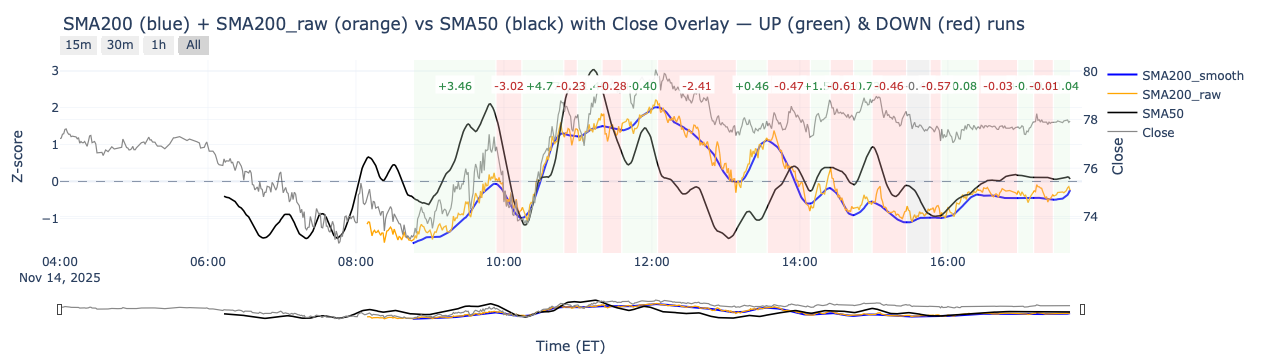

In [9]:

# ===== Inputs =====
# Add example 100 tickers

TICKERS=['CRWV']

# Time window for filtering intraday bars (Eastern Time)

# ===== Inputs =====
start_date_DATA = date(2025, 11, 14)
end_date_DATA = date(2025, 11, 14)

start_time_DATA = dt_time(0, 0)   # ex.,4:00 AM ET
end_time_DATA = dt_time(20, 0)    #ex.,4:00 PM ET
#--------------------------------------------------
start_date_TRADE = date(2025, 11, 14)
end_date_TRADE = date(2025, 11, 14)

start_time_TRADE = dt_time(0, 0)   # ex.,4:00 AM ET
end_time_TRADE = dt_time(23, 59)    #ex.,4:00 PM ET


from IPython.display import clear_output
import time
import sys
import pandas as pd  # only if you print timestamps

REFRESH_EVERY = 55  # seconds



# 🔽 Put your entire analysis/plot/table code here
    #===========================================================================================================================================
        
    # ─────────────────────────────────────────────────────────────────────
    # GET DATA
    # ─────────────────────────────────────────────────────────────────────
multiplier = 1               #   e.g., 1-minute bars,  5-minute bars, etc.
timespan = "minute"          #  "second", "minute", "hour", "day", etc.
limit = 50000
        
all_data_minute = fetch_multiple_tickers_data(ticker=TICKERS,api_key=API_KEY,start_date=start_date_DATA,end_date=end_date_DATA,start_time=start_time_DATA,end_time=end_time_DATA,multiplier=multiplier,timespan=timespan,limit=limit)
        
    # ─────────────────────────────────────────────────────────────────────
    # Do Not  plot
    # ─────────────────────────────────────────────────────────────────────
for tic in TICKERS:
            # df_day = all_data_minute_processed.get(tic)
 df_day = all_data_minute.get(tic)
        
    # ─────────────────────────────────────────────────────────────────────
    # ONE-LINE USAGE IN THE SAME CELL
    # ─────────────────────────────────────────────────────────────────────
runs_up, runs_down, fig = analyze_sma_runs(df_day,start_date_TRADE,end_date_TRADE,start_time_TRADE,end_time_TRADE)
    
display(runs_up)
display(runs_down)
fig.show()
    
    #===========================================================================================================================================








In [10]:
def backtest_live_runs(
    df_day,
    start_date_TRADE,
    end_date_TRADE,
    start_time_TRADE,
    end_time_TRADE,
    time_col="TIME_EST",
):
    """
    Simulate 'live' usage of analyze_sma_runs.
    At each bar t, only data up to t is visible.

    Returns:
        df_signals: df_day with extra columns:
            - live_run_state: 'up', 'down', or None
            - live_last_delta: Δ of the *last completed run* at that time (NaN if none)
    """
    df_sorted = df_day.sort_values(time_col).copy()
    df_sorted[time_col] = pd.to_datetime(df_sorted[time_col], errors="coerce")

    live_state_list = []
    live_delta_list = []

    for i in range(len(df_sorted)):
        # History up to *and including* this bar
        df_live = df_sorted.iloc[: i + 1].copy()

        # Call your existing analyzer on *partial* data
        runs_up, runs_down, _ = analyze_sma_runs(
            df_live,
            start_date_TRADE,
            end_date_TRADE,
            start_time_TRADE,
            end_time_TRADE,
        )

        # Default: no run yet
        state = None
        last_delta = np.nan

        # Decide "what do we know at this bar?"
        # Here: we look at the last *completed* up/down run in the partial history
        if not runs_up.empty:
            last_up = runs_up.iloc[-1]
            last_delta = last_up["Δ"]
            state = "up"

        if not runs_down.empty:
            last_down = runs_down.iloc[-1]
            # If the last down run ends later than last up run, overwrite
            if runs_up.empty or last_down["End EST"] >= last_up["End EST"]:
                last_delta = last_down["Δ"]
                state = "down"

        live_state_list.append(state)
        live_delta_list.append(last_delta)

    df_sorted["live_run_state"] = live_state_list
    df_sorted["live_last_delta"] = live_delta_list

    return df_sorted
    


✅ CRWV - fetched 775 rows


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
0,08:47,09:53,73.240,76.7000,3.4600,4.724194,66.0,13.906852,17.362670,05:47,06:53
1,10:15,10:48,73.940,78.7100,4.7700,6.451177,33.0,23.675786,24.192354,07:15,07:48
2,11:00,11:19,78.220,79.7100,1.4900,1.904884,19.0,8.038700,11.186571,08:00,08:19
3,11:36,12:04,79.510,79.9068,0.3968,0.499057,28.0,6.139303,14.532090,08:36,09:04
4,13:09,13:33,77.490,77.9465,0.4565,0.589108,24.0,7.079490,23.999295,10:09,10:33
5,14:09,14:24,77.315,78.8194,1.5044,1.945806,15.0,22.423283,21.939423,11:09,11:24
6,14:44,14:58,77.970,78.6968,0.7268,0.932153,14.0,14.441251,25.280920,11:44,11:58
7,15:27,15:45,78.155,77.7050,-0.4500,-0.575779,18.0,3.908137,3.933802,12:27,12:45
8,15:55,16:24,77.615,77.6900,0.0750,0.096631,29.0,6.706441,13.466653,12:55,13:24
9,16:53,17:03,77.600,77.3900,-0.2100,-0.270619,10.0,3.970022,4.646251,13:53,14:03


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
0,09:54,10:14,76.8800,73.8600,-3.0200,-3.928200,20.0,-26.792912,-27.888769,06:54,07:14
1,10:49,10:59,78.3200,78.0862,-0.2338,-0.298519,10.0,-11.444636,-7.324126,07:49,07:59
2,11:20,11:35,79.4600,79.1800,-0.2800,-0.352379,15.0,-4.702691,-9.259082,08:20,08:35
3,12:05,13:08,79.7500,77.3408,-2.4092,-3.020940,63.0,-13.094619,-14.610350,09:05,10:08
4,13:34,14:08,77.7390,77.2723,-0.4667,-0.600342,34.0,-18.001338,-18.632587,10:34,11:08
5,14:25,14:43,78.7200,78.1100,-0.6100,-0.774898,18.0,-23.534578,-23.622778,11:25,11:43
6,14:59,15:26,78.8111,78.3484,-0.4627,-0.587100,27.0,-11.821614,-9.733162,11:59,12:26
7,15:46,15:54,77.6900,77.1200,-0.5700,-0.733685,8.0,-2.240333,-3.570177,12:46,12:54
8,16:25,16:52,77.7000,77.6915,-0.0085,-0.010940,27.0,-6.239673,-6.128758,13:25,13:52
9,17:04,17:14,77.5300,77.9999,0.4699,0.606088,10.0,-7.908464,-4.736602,14:04,14:14


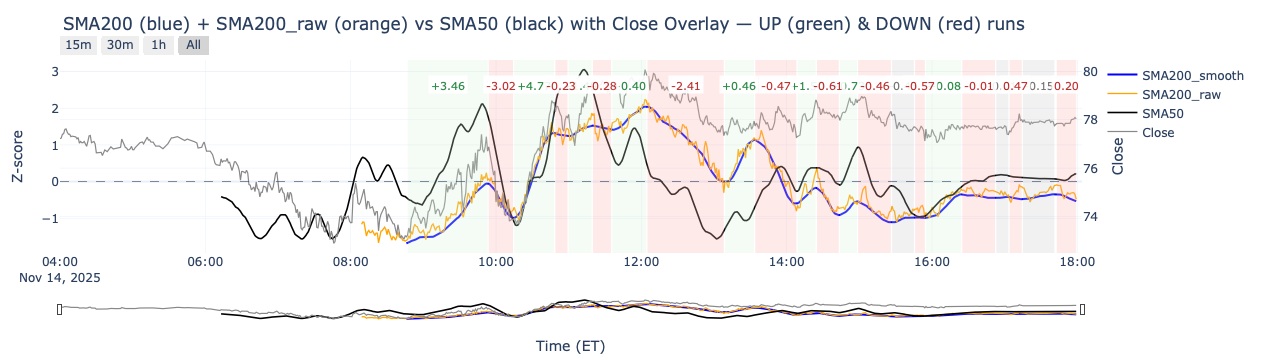

In [13]:
# ─────────────────────────────────────────────────────────────────────
# GET DATA
# ─────────────────────────────────────────────────────────────────────
multiplier = 1
timespan   = "minute"
limit      = 50000

all_data_minute = fetch_multiple_tickers_data(
    ticker=TICKERS,
    api_key=API_KEY,
    start_date=start_date_DATA,
    end_date=end_date_DATA,
    start_time=start_time_DATA,
    end_time=end_time_DATA,
    multiplier=multiplier,
    timespan=timespan,
    limit=limit,
)

for tic in TICKERS:
    df_day = all_data_minute.get(tic)

    # ===== 1) Live-style backtest =====
    df_signals = backtest_live_runs(
        df_day,
        start_date_TRADE,
        end_date_TRADE,
        start_time_TRADE,
        end_time_TRADE,
        time_col="TIME_EST",
    )

    # Now df_signals has *per-bar* "live" info:
    #   - df_signals["live_run_state"]  -> 'up' / 'down' / None
    #   - df_signals["live_last_delta"] -> last known Δ at that time

    # display(df_signals.tail(20))   # see last bars with live signals

    # ===== 2) Final full-day analysis + plot (optional) =====
    runs_up, runs_down, fig = analyze_sma_runs(
        df_day,
        start_date_TRADE,
        end_date_TRADE,
        start_time_TRADE,
        end_time_TRADE,
    )

    display(runs_up)
    display(runs_down)
    fig.show()


=== FULL-DAY ANALYSIS (sanity check) ===
UP runs (last 5 rows):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
6,14:44,14:58,77.970,78.6968,0.7268,0.932153,14.0,14.466101,25.324422,11:44,11:58
7,15:27,15:45,78.155,77.7050,-0.4500,-0.575779,18.0,3.914862,3.940571,12:27,12:45
8,15:55,16:24,77.615,77.6900,0.0750,0.096631,29.0,6.717981,13.489826,12:55,13:24
9,16:53,17:03,77.600,77.3900,-0.2100,-0.270619,10.0,3.976853,4.654246,13:53,14:03
10,17:15,17:43,77.900,77.8435,-0.0565,-0.072529,28.0,2.628446,3.902952,14:15,14:43



DOWN runs (last 5 rows):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
6,14:59,15:26,78.8111,78.3484,-0.4627,-0.587100,27.0,-11.841956,-9.749910,11:59,12:26
7,15:46,15:54,77.6900,77.1200,-0.5700,-0.733685,8.0,-2.244188,-3.576320,12:46,12:54
8,16:25,16:52,77.7000,77.6915,-0.0085,-0.010940,27.0,-6.250409,-6.139304,13:25,13:52
9,17:04,17:14,77.5300,77.9999,0.4699,0.606088,10.0,-7.922073,-4.555962,14:04,14:14
10,17:44,18:02,77.8500,78.0900,0.2400,0.308285,18.0,-7.175859,-15.936126,14:44,15:02


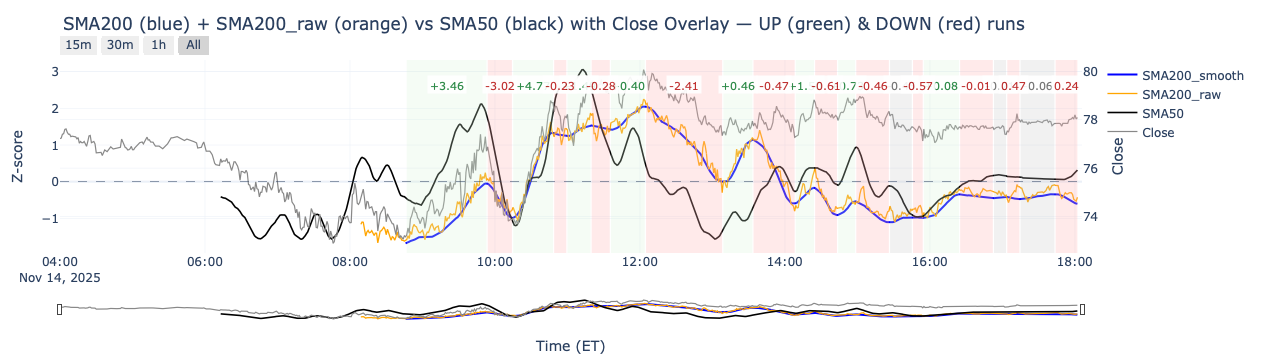



=== SNAPSHOT REPLAY (partial-day frames) ===

------------------------------
Frame 1/6 — bar 41/778
Current time in df_live: 2025-11-14 04:47:00-05:00
------------------------------
UP runs (last few):
  none yet

DOWN runs (last few):
  none yet


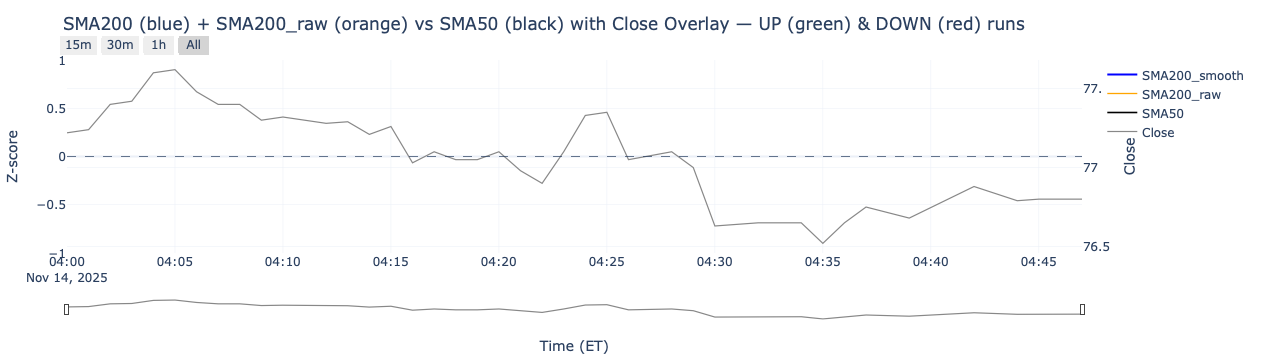


------------------------------
Frame 2/6 — bar 188/778
Current time in df_live: 2025-11-14 07:56:00-05:00
------------------------------
UP runs (last few):
  none yet

DOWN runs (last few):
  none yet


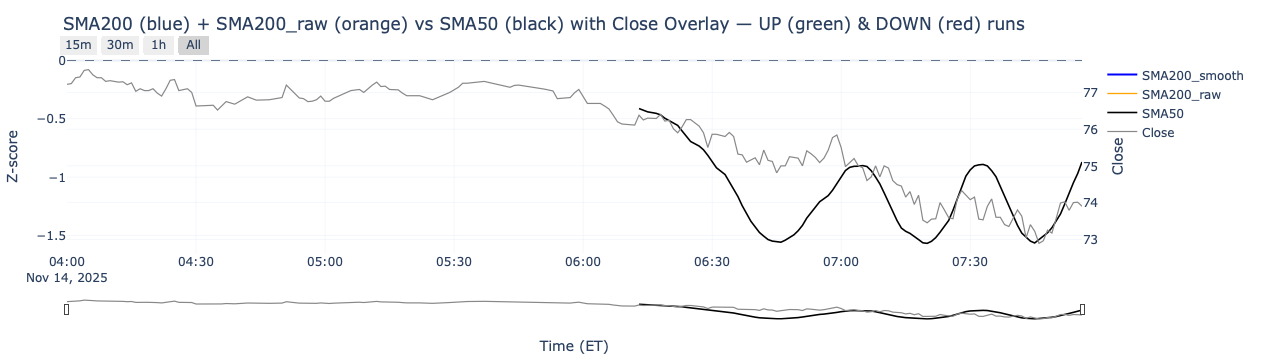


------------------------------
Frame 3/6 — bar 335/778
Current time in df_live: 2025-11-14 10:23:00-05:00
------------------------------
UP runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
0,08:47,09:53,73.24,76.70,3.46,4.724194,66.0,13.930782,17.392546,05:47,06:53
1,10:15,10:23,73.94,74.34,0.40,0.540979,8.0,23.716525,56.561940,07:15,07:23



DOWN runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
0,09:54,10:14,76.88,73.86,-3.02,-3.9282,20.0,-26.839015,-27.936757,06:54,07:14


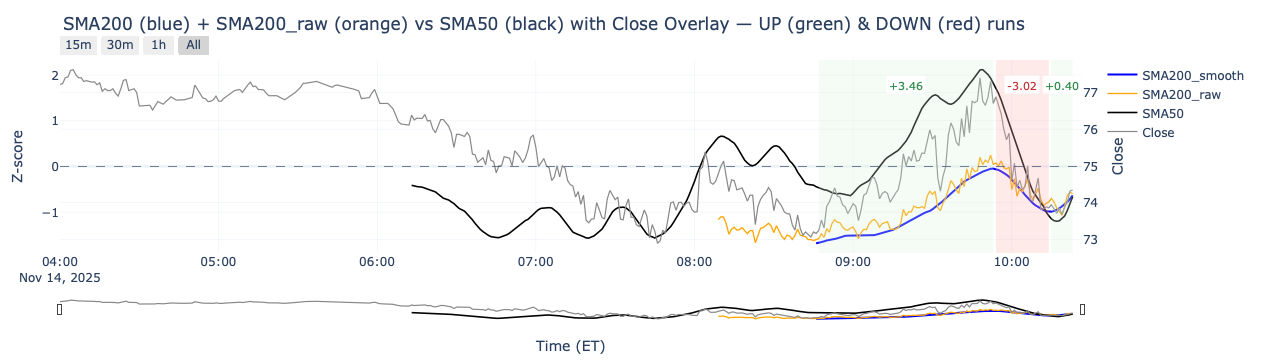


------------------------------
Frame 4/6 — bar 483/778
Current time in df_live: 2025-11-14 12:51:00-05:00
------------------------------
UP runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
1,10:15,10:48,73.94,78.7100,4.7700,6.451177,33.0,23.716525,24.233982,07:15,07:48
2,11:00,11:19,78.22,79.7100,1.4900,1.904884,19.0,8.052532,11.205820,08:00,08:19
3,11:36,12:04,79.51,79.9068,0.3968,0.499057,28.0,6.149867,14.557095,08:36,09:04



DOWN runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
1,10:49,10:59,78.32,78.0862,-0.2338,-0.298519,10.0,-11.464329,-7.336728,07:49,07:59
2,11:20,11:35,79.46,79.1800,-0.2800,-0.352379,15.0,-4.710783,-9.275014,08:20,08:35
3,12:05,12:51,79.75,77.7850,-1.9650,-2.463950,46.0,-13.117151,-41.681309,09:05,09:51


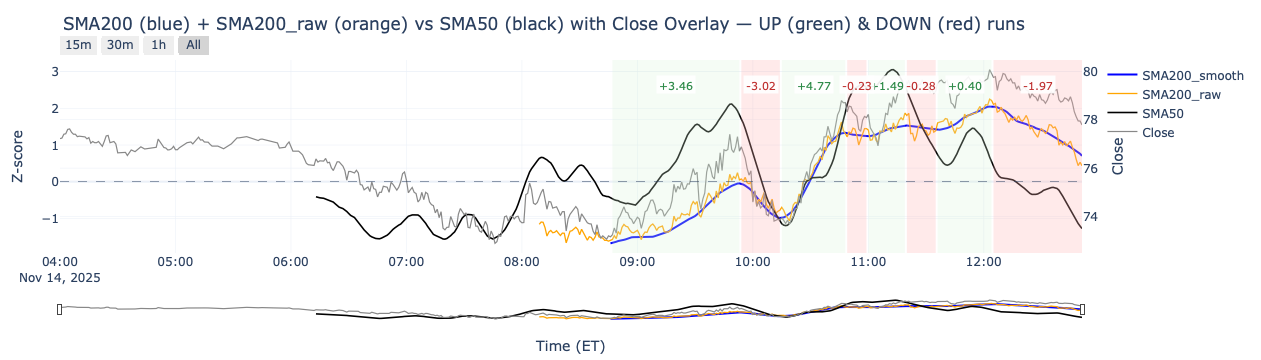


------------------------------
Frame 5/6 — bar 630/778
Current time in df_live: 2025-11-14 15:18:00-05:00
------------------------------
UP runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
4,13:09,13:33,77.490,77.9465,0.4565,0.589108,24.0,7.091672,24.040591,10:09,10:33
5,14:09,14:24,77.315,78.8194,1.5044,1.945806,15.0,22.461867,21.977175,11:09,11:24
6,14:44,14:58,77.970,78.6968,0.7268,0.932153,14.0,14.466101,25.324422,11:44,11:58



DOWN runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
4,13:34,14:08,77.7390,77.2723,-0.4667,-0.600342,34.0,-18.032313,-18.664648,10:34,11:08
5,14:25,14:43,78.7200,78.1100,-0.6100,-0.774898,18.0,-23.575075,-23.663426,11:25,11:43
6,14:59,15:18,78.8111,77.9000,-0.9111,-1.156055,19.0,-11.841956,-24.700520,11:59,12:18


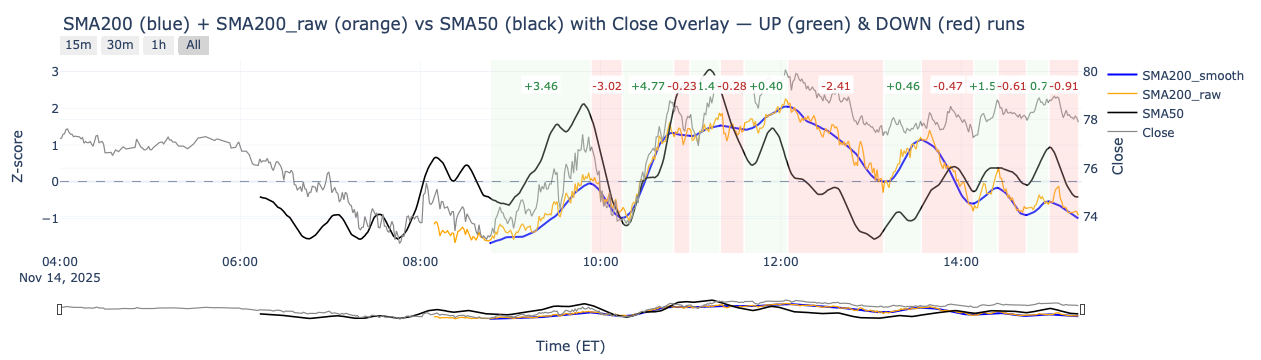


------------------------------
Frame 6/6 — bar 778/778
Current time in df_live: 2025-11-14 18:02:00-05:00
------------------------------
UP runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
8,15:55,16:24,77.615,77.6900,0.0750,0.096631,29.0,6.717981,13.489826,12:55,13:24
9,16:53,17:03,77.600,77.3900,-0.2100,-0.270619,10.0,3.976853,4.654246,13:53,14:03
10,17:15,17:43,77.900,77.8435,-0.0565,-0.072529,28.0,2.628446,3.902952,14:15,14:43



DOWN runs (last few):


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
8,16:25,16:52,77.70,77.6915,-0.0085,-0.010940,27.0,-6.250409,-6.139304,13:25,13:52
9,17:04,17:14,77.53,77.9999,0.4699,0.606088,10.0,-7.922073,-4.555962,14:04,14:14
10,17:44,18:02,77.85,78.0900,0.2400,0.308285,18.0,-7.175859,-15.936126,14:44,15:02


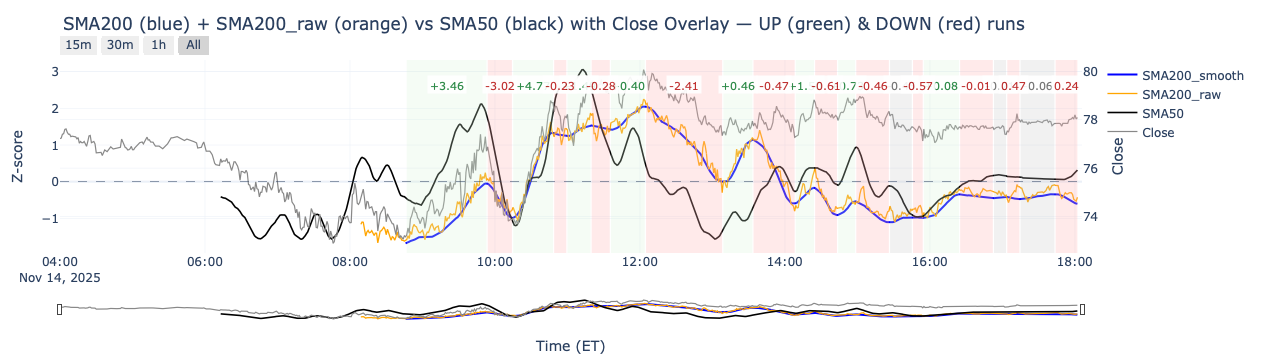


Replay finished. Scroll up to compare frames.


In [20]:
from IPython.display import display
import numpy as np
import pandas as pd

# ============================================================
# 1) QUICK SANITY: full-day analysis once (full table + plot)
# ============================================================
print("=== FULL-DAY ANALYSIS (sanity check) ===")
runs_up_full, runs_down_full, fig_full = analyze_sma_runs(
    df_day,
    start_date_TRADE,
    end_date_TRADE,
    start_time_TRADE,
    end_time_TRADE,
)

print("UP runs (last 5 rows):")
if not runs_up_full.empty:
    display(runs_up_full.tail(5))
else:
    print("  none")

print("\nDOWN runs (last 5 rows):")
if not runs_down_full.empty:
    display(runs_down_full.tail(5))
else:
    print("  none")

fig_full.show()

# ============================================================
# 2) SNAPSHOT REPLAY: see tables + plot as day builds up
# ============================================================
def replay_sma_runs_day_snapshots(
    df_day,
    start_date_TRADE,
    end_date_TRADE,
    start_time_TRADE,
    end_time_TRADE,
    time_col="TIME_EST",
    min_bars=40,      # need at least this many bars before first snapshot
    num_frames=6,     # how many snapshots to show (keep small so it's fast)
):
    """
    Snapshot 'movie' of the day.

    At each frame:
      - Only bars up to that time are visible (no future data).
      - Calls analyze_sma_runs(df_live, ...) on partial history.
      - Shows last few rows of UP/DOWN tables + your plot.

    No clear_output, no sleep => all frames stay visible in the notebook.
    """
    # 1) Sort dataframe by time
    df_sorted = df_day.sort_values(time_col).copy()
    df_sorted[time_col] = pd.to_datetime(df_sorted[time_col], errors="coerce")

    n = len(df_sorted)
    if n < min_bars:
        raise ValueError(f"Not enough bars ({n}) for replay. Reduce min_bars or fetch more data.")

    # 2) Pick num_frames indices from min_bars..(n-1)
    frame_indices = np.linspace(min_bars, n - 1, num_frames, dtype=int)

    print("\n\n=== SNAPSHOT REPLAY (partial-day frames) ===")

    for frame_idx, i in enumerate(frame_indices):
        df_live = df_sorted.iloc[: i + 1].copy()
        current_ts = df_live[time_col].iloc[-1]

        # Analyze *partial* history up to this bar only
        runs_up, runs_down, fig = analyze_sma_runs(
            df_live,
            start_date_TRADE,
            end_date_TRADE,
            start_time_TRADE,
            end_time_TRADE,
        )

        print(f"\n------------------------------")
        print(f"Frame {frame_idx+1}/{len(frame_indices)} — bar {i+1}/{n}")
        print(f"Current time in df_live: {current_ts}")
        print(f"------------------------------")

        print("UP runs (last few):")
        if not runs_up.empty:
            display(runs_up.tail(3))
        else:
            print("  none yet")

        print("\nDOWN runs (last few):")
        if not runs_down.empty:
            display(runs_down.tail(3))
        else:
            print("  none yet")

        # Your real plot for this partial history
        fig.show()

    print("\nReplay finished. Scroll up to compare frames.")

# ============================================================
# 3) RUN SNAPSHOT REPLAY
# ============================================================
replay_sma_runs_day_snapshots(
    df_day,
    start_date_TRADE,
    end_date_TRADE,
    start_time_TRADE,
    end_time_TRADE,
    time_col="TIME_EST",
    min_bars=40,   # start snapshots after some history
    num_frames=6,  # 6 frames = start/middle/end-ish
)
